In [1]:
#!/usr/bin/env python3
import numpy as np
import cv2
import sys
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque
import pickle
import time

from lesson_functions import *
from hyperparameters import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

with open("classified.p", "rb") as cf:
    pickled = pickle.load(cf)
    svc = pickled["svc"]
    X_scaler = pickled["X_scaler"]


In [3]:
heat_stack = deque(maxlen=5)


In [4]:
def find_hot_windows(image, y_start_stop, x_start_stop, xy_window, xy_overlap):
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    hot_win = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    return windows, hot_win


In [5]:
def run_image(image):
    # win_xl, hot_xl = find_hot_windows(image, y_start_stop_xl, x_start_stop_xl, (WS * 9, WS * 9), (0.75, 0.75))
    win_lg, hot_lg = find_hot_windows(image, y_start_stop_lg, x_start_stop_lg, (WS * 6, WS * 6), (0.75, 0.75))
    win_md, hot_md = find_hot_windows(image, y_start_stop_md, x_start_stop_md, (WS * 3, WS * 3), (0.8, 0.8))
    win_sm, hot_sm = find_hot_windows(image, y_start_stop_sm, x_start_stop_sm, (WS    , WS    ), (0.5, 0.5))
    
    # Draw Hot windows as red
    window_img = np.copy(image)
    # window_img = draw_boxes(window_img, hot_xl, color=(1, 0, 0), thick=6)
    window_img = draw_boxes(window_img, hot_lg, color=(1, 0, 0), thick=6)
    window_img = draw_boxes(window_img, hot_md, color=(1, 0, 0), thick=6)
    window_img = draw_boxes(window_img, hot_sm, color=(1, 0, 0), thick=6)

    # draw all windows
    # window_img = draw_boxes(window_img, win_xl, color=(1,1,0), thick=1)
    window_img = draw_boxes(window_img, win_lg, color=(0,1,0), thick=1)
    window_img = draw_boxes(window_img, win_md, color=(0,0,1), thick=1)
    window_img = draw_boxes(window_img, win_sm, color=(0,1,1), thick=1)

    # Add heat to each box in box list
    heat = np.zeros( (720, 1280) ).astype(np.float)
    # heat = add_heat(heat, hot_xl)
    heat = add_heat(heat, hot_lg)
    heat = add_heat(heat, hot_md)
    heat = add_heat(heat, hot_sm)
    
    heat_stack.appendleft(heat)
    
    avg_heat = np.mean(heat_stack, axis=0)
    
    # Apply threshold to help remove false positives
    avg_heat = apply_threshold(avg_heat, 1)

    # Visualize the heatmap when displaying
    hmap = np.clip(avg_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(hmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return window_img, hmap, draw_img


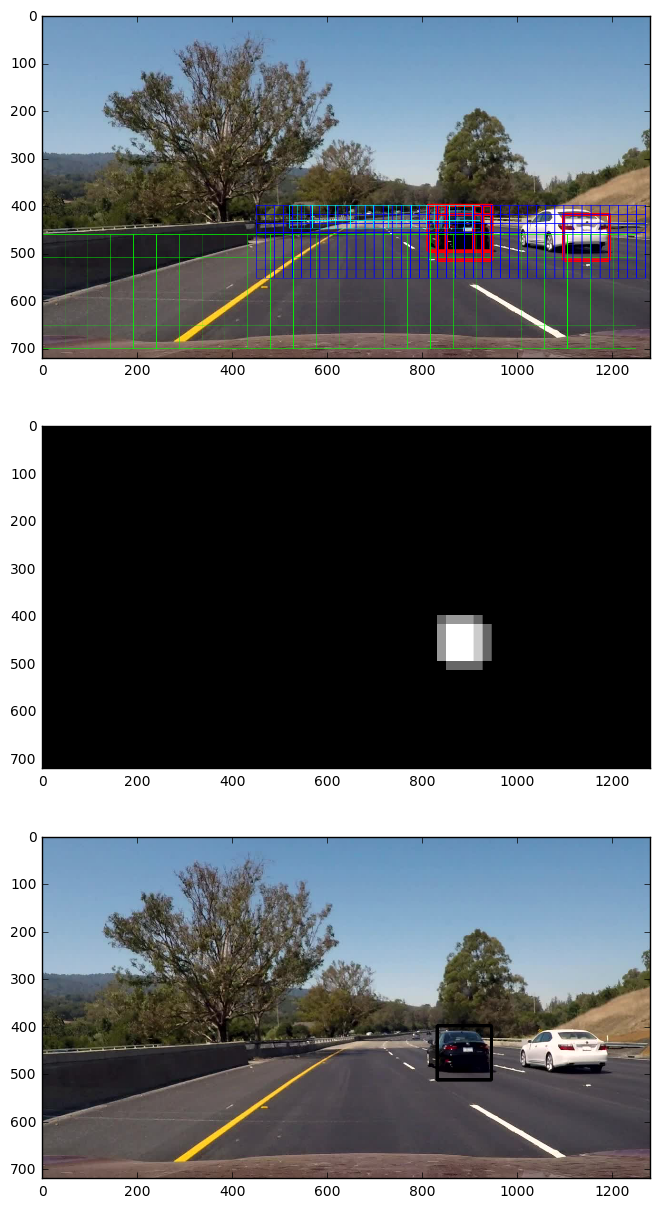

In [6]:
image = mpimg.imread("file.jpg")
image = image.astype(np.float32) / 255.
window_img, heatmap, draw_img = run_image(image)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 15))
ax1.imshow(window_img)
ax2.imshow(heatmap, cmap='gray')
ax3.imshow(draw_img)
plt.show()

In [18]:
def run_vid(img):
    img = img.astype(np.float32)/255.0
    window_img, heatmap, draw_img = run_image(img)
    hxmap = np.dstack( (heatmap, heatmap, heatmap) ) * 30
    return np.vstack( (window_img, hxmap, draw_img) ) * 255

vid_name = "test_video.mp4"

# clip = VideoFileClip(vid_name)
# output = clip.fl_image(run_vid)
# output.write_videofile("output_images/" + str(time.time()) + "_" + vid_name, audio=False)
